In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
num_simulations = 100_000

Starting with base T3.
Data from maxroll.gg and easymari.com

In [3]:
resources = ['rocks', 'shards', 'stones', 'fusion', 'silver', 'gold']

In [4]:
probabilities = pd.DataFrame(
    columns=('level', 'ilvl', 'base_rate'),
    data=[
        ( 1, 1304, 1.00),
        ( 2, 1307, 1.00),
        ( 3, 1310, 1.00),
        ( 4, 1315, 1.00),
        ( 5, 1320, 1.00),
        ( 6, 1325, 1.00),
        ( 7, 1330, 0.60),
        ( 8, 1335, 0.45),
        ( 9, 1340, 0.30),
        (10, 1345, 0.30),
        (11, 1350, 0.30),
        (12, 1355, 0.15),
        (13, 1360, 0.15),
        (14, 1365, 0.15),
        (15, 1370, 0.10),
    ]
)
probabilities

,level,ilvl,base_rate
0,1,1304,1.00
1,2,1307,1.00
2,3,1310,1.00
3,4,1315,1.00
4,5,1320,1.00
5,6,1325,1.00
6,7,1330,0.60
7,8,1335,0.45
8,9,1340,0.30
9,10,1345,0.30


In [5]:
gear_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 1,  82, 22, 2, 0, 11100,  0),
        ( 2,  82, 22, 2, 0, 11380,  0),
        ( 3,  82, 22, 2, 0, 11660,  0),
        ( 4, 120, 32, 4, 2, 11960,  0),
        ( 5, 120, 32, 4, 2, 12240,  0),
        ( 6, 120, 32, 4, 2, 12540,  0),
        ( 7, 156, 42, 4, 2, 12840, 70),
        ( 8, 156, 42, 4, 2, 13160, 70),
        ( 9, 156, 42, 4, 2, 13480, 70),
        (10, 192, 50, 6, 4, 13820, 70),
        (11, 192, 50, 6, 4, 14140, 70),
        (12, 192, 50, 6, 4, 14500, 70),
        (13, 228, 60, 6, 4, 14860, 70),  # this 6 stones seems wrong, should be 8?
        (14, 228, 60, 8, 4, 15220, 70),
        (15, 228, 60, 8, 4, 15600, 70),
    ]
)
gear_costs

,level,rocks,shards,stones,fusion,silver,gold
0,1,82,22,2,0,11100,0
1,2,82,22,2,0,11380,0
2,3,82,22,2,0,11660,0
3,4,120,32,4,2,11960,0
4,5,120,32,4,2,12240,0
5,6,120,32,4,2,12540,0
6,7,156,42,4,2,12840,70
7,8,156,42,4,2,13160,70
8,9,156,42,4,2,13480,70
9,10,192,50,6,4,13820,70


In [6]:
weapon_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 1, 138, 32,  4, 0, 15860,   0),
        ( 2, 138, 32,  4, 0, 16240,   0),
        ( 3, 198, 32,  6, 0, 16550,   0),  # rocks increase at lvl 4 for gear, weapon at 3, is this correct?
        ( 4, 198, 46,  6, 2, 17040,   0),
        ( 5, 198, 46,  6, 2, 17460,   0),
        ( 6, 198, 46,  6, 2, 17900,   0),
        ( 7, 258, 60,  8, 4, 18320, 120),
        ( 8, 258, 60,  8, 4, 18780, 120),
        ( 9, 258, 60,  8, 4, 19240, 120),
        (10, 320, 74, 10, 4, 19720, 120),
        (11, 320, 74, 10, 4, 20200, 120),
        (12, 320, 74, 10, 4, 20700, 120),
        (13, 380, 88, 10, 6, 21200, 120),
        (14, 380, 88, 12, 6, 21720, 120),
        (15, 380, 88, 12, 6, 22260, 120),
    ]
)
weapon_costs

,level,rocks,shards,stones,fusion,silver,gold
0,1,138,32,4,0,15860,0
1,2,138,32,4,0,16240,0
2,3,198,32,6,0,16550,0
3,4,198,46,6,2,17040,0
4,5,198,46,6,2,17460,0
5,6,198,46,6,2,17900,0
6,7,258,60,8,4,18320,120
7,8,258,60,8,4,18780,120
8,9,258,60,8,4,19240,120
9,10,320,74,10,4,19720,120


According to [earymari](https://www.easymari.com/en/t3_gear_honing_statistics) the success rate for an item increases by 0.1 * base_rate and artisan rate increases by 0.456 * current_rate. Upgrade chance becomes 100% once artisan rate reaches 100%. Success rate caps at 2 * base_rate.

In [7]:
rates = []
for _, row in probabilities.iterrows():
    attempt = 0
    artisan_rate = 0.00
    success_rate = row.base_rate
    increase_rate = row.base_rate * 0.1
    while True:
        attempt += 1
        if artisan_rate >= 1 or success_rate >= 1:
            break
        rates.append((row.level, attempt, success_rate))
        artisan_rate = np.round(artisan_rate + 0.465 * success_rate, 4)
        success_rate = np.round(np.min([success_rate + increase_rate, 2 * row.base_rate]), 4)
    rates.append((row.level, attempt, 1.0))

rates = pd.DataFrame(rates, columns=('level', 'attempts', 'success_rate'))
# rates.to_csv('rates.csv', index=False)
rates

,level,attempts,success_rate
0,1.0,1,1.0
1,2.0,1,1.0
2,3.0,1,1.0
3,4.0,1,1.0
4,5.0,1,1.0
...,...,...,...
81,15.0,11,0.2
82,15.0,12,0.2
83,15.0,13,0.2
84,15.0,14,0.2


In [8]:
df = (
    pd.concat([
        rates.assign(trial=i+1)
        for i in range(num_simulations)
    ])
    .assign(roll=np.random.uniform(size=rates.shape[0]*num_simulations))
    .query('roll < success_rate')
    .drop(['roll', 'success_rate'], axis=1)
    .groupby(['trial', 'level'], as_index=False)
    .first()
)

df

,trial,level,attempts
0,1,1.0,1
1,1,2.0,1
2,1,3.0,1
3,1,4.0,1
4,1,5.0,1
...,...,...,...
1499995,100000,11.0,1
1499996,100000,12.0,6
1499997,100000,13.0,3
1499998,100000,14.0,3


In [9]:
df.pivot(index='trial', columns='level')

attempts                                                              \
level      1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 11.0 12.0 13.0   
trial                                                                         
1             1    1    1    1    1    1    1    3    1    1    3    4    5   
2             1    1    1    1    1    1    1    1    2    2    2    1    4   
3             1    1    1    1    1    1    1    3    3    1    5    1    8   
4             1    1    1    1    1    1    2    2    1    4    3    1    3   
5             1    1    1    1    1    1    3    1    2    2    1    2    1   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99996         1    1    1    1    1    1    1    1    2    2    3    3   11   
99997         1    1    1    1    1    1    1    3    1    4    2   11    2   
99998         1    1    1    1    1    1    1    5    1    2    3    6    5   
99999         1    1    1    1    1    1    3    3    2    1    3    2    1   
100000        1    1    1    1    1    1    2    5    2    1    1    6    3   

                  
level  14.0 15.0  
trial             
1        10    9  
2         4    2  
3         2   10  
4         1    2  
5        11    2  
...     ...  ...  
99996     5    9  
99997     6    2  
99998     2    4  
99999     4   12  
100000    3    9  

[100000 rows x 15 columns]

<AxesSubplot:xlabel='level', ylabel='attempts'>

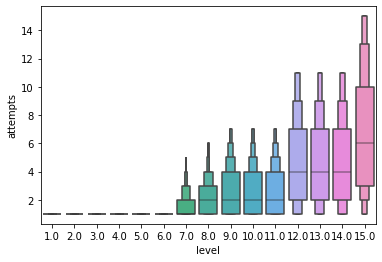

In [10]:
sb.boxenplot(data=df, x='level', y='attempts')

cummulative success probabilities

In [11]:
(
    (
        df
        .drop('trial', axis=1)
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempts')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .fillna('--')
)

p                                                              \
attempts    1     2     3     4     5     6     7     8     9     10    11   
level                                                                        
1.0       1.00    --    --    --    --    --    --    --    --    --    --   
2.0       1.00    --    --    --    --    --    --    --    --    --    --   
3.0       1.00    --    --    --    --    --    --    --    --    --    --   
4.0       1.00    --    --    --    --    --    --    --    --    --    --   
5.0       1.00    --    --    --    --    --    --    --    --    --    --   
6.0       1.00    --    --    --    --    --    --    --    --    --    --   
7.0       0.60  0.87  0.96  0.99   1.0    --    --    --    --    --    --   
8.0       0.45  0.72  0.87  0.95  0.98   1.0    --    --    --    --    --   
9.0       0.30  0.53   0.7  0.82  0.89  0.94   1.0    --    --    --    --   
10.0      0.30  0.53   0.7  0.82  0.89  0.94   1.0    --    --    --    --   
11.0      0.30  0.53   0.7  0.82  0.89  0.94   1.0    --    --    --    --   
12.0      0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.92   1.0   
13.0      0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.92   1.0   
14.0      0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.91   1.0   
15.0      0.10   0.2   0.3  0.39  0.47  0.55  0.62  0.69  0.74  0.79  0.83   

                                 
attempts    12    13    14   15  
level                            
1.0         --    --    --   --  
2.0         --    --    --   --  
3.0         --    --    --   --  
4.0         --    --    --   --  
5.0         --    --    --   --  
6.0         --    --    --   --  
7.0         --    --    --   --  
8.0         --    --    --   --  
9.0         --    --    --   --  
10.0        --    --    --   --  
11.0        --    --    --   --  
12.0        --    --    --   --  
13.0        --    --    --   --  
14.0        --    --    --   --  
15.0      0.87  0.89  0.92  1.0

failure rates by level

In [12]:
(
    (
        df
        .drop('trial', axis=1)
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempts')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .applymap(lambda p: 1-p)
    .fillna('--')
)

p                                                              \
attempts    1     2     3     4     5     6     7     8     9     10    11   
level                                                                        
1.0       0.00    --    --    --    --    --    --    --    --    --    --   
2.0       0.00    --    --    --    --    --    --    --    --    --    --   
3.0       0.00    --    --    --    --    --    --    --    --    --    --   
4.0       0.00    --    --    --    --    --    --    --    --    --    --   
5.0       0.00    --    --    --    --    --    --    --    --    --    --   
6.0       0.00    --    --    --    --    --    --    --    --    --    --   
7.0       0.40  0.13  0.04  0.01   0.0    --    --    --    --    --    --   
8.0       0.55  0.28  0.13  0.05  0.02   0.0    --    --    --    --    --   
9.0       0.70  0.47   0.3  0.18  0.11  0.06   0.0    --    --    --    --   
10.0      0.70  0.47   0.3  0.18  0.11  0.06   0.0    --    --    --    --   
11.0      0.70  0.47   0.3  0.18  0.11  0.06   0.0    --    --    --    --   
12.0      0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.08   0.0   
13.0      0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.08   0.0   
14.0      0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.09   0.0   
15.0      0.90   0.8   0.7  0.61  0.53  0.45  0.38  0.31  0.26  0.21  0.17   

                                 
attempts    12    13    14   15  
level                            
1.0         --    --    --   --  
2.0         --    --    --   --  
3.0         --    --    --   --  
4.0         --    --    --   --  
5.0         --    --    --   --  
6.0         --    --    --   --  
7.0         --    --    --   --  
8.0         --    --    --   --  
9.0         --    --    --   --  
10.0        --    --    --   --  
11.0        --    --    --   --  
12.0        --    --    --   --  
13.0        --    --    --   --  
14.0        --    --    --   --  
15.0      0.13  0.11  0.08  0.0

expected attempts per level

In [13]:
stats = df.drop('trial', axis=1).groupby('level').describe(percentiles=[0.5])
stats.columns = ['_'.join(col) for col in stats.columns.to_flat_index()]
stats = (
    stats
    .reset_index()
    .drop(['attempts_count', 'attempts_mean', 'attempts_std'] , axis=1)
    .astype(int)
)
stats

,level,attempts_min,attempts_50%,attempts_max
0,1,1,1,1
1,2,1,1,1
2,3,1,1,1
3,4,1,1,1
4,5,1,1,1
5,6,1,1,1
6,7,1,1,5
7,8,1,2,6
8,9,1,2,7
9,10,1,2,7


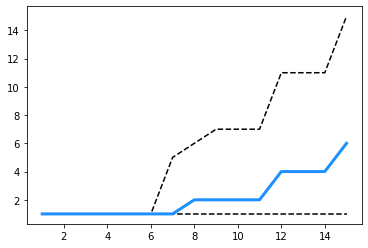

In [14]:
plt.plot(stats['level'], stats['attempts_min'], color='black', ls='--')
plt.plot(stats['level'], stats['attempts_max'], color='black', ls='--')
plt.plot(stats['level'], stats['attempts_50%'], color='dodgerblue', lw=3)

cummulative total attempts to +15

In [15]:
(
    stats
    .drop('level', axis=1)
    .apply(np.cumsum)
    .assign(level=stats['level'])
)

,attempts_min,attempts_50%,attempts_max,level
0,1,1,1,1
1,2,2,2,2
2,3,3,3,3
3,4,4,4,4
4,5,5,5,5
5,6,6,6,6
6,7,7,11,7
7,8,9,17,8
8,9,11,24,9
9,10,13,31,10


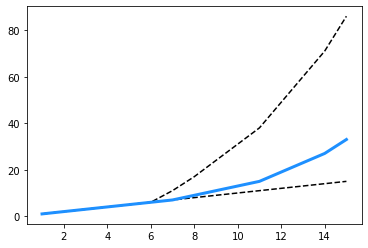

In [16]:
plt.plot(stats['level'], stats['attempts_min'].cumsum(), color='black', ls='--')
plt.plot(stats['level'], stats['attempts_max'].cumsum(), color='black', ls='--')
plt.plot(stats['level'], stats['attempts_50%'].cumsum(), color='dodgerblue', lw=3)

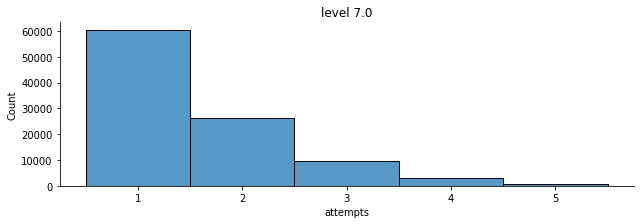

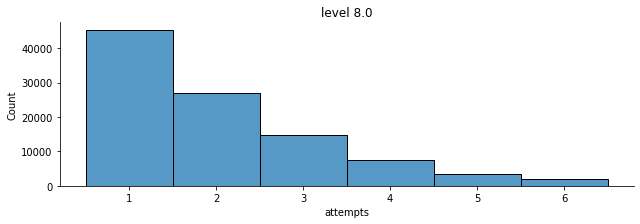

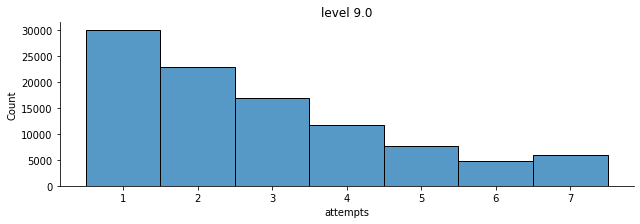

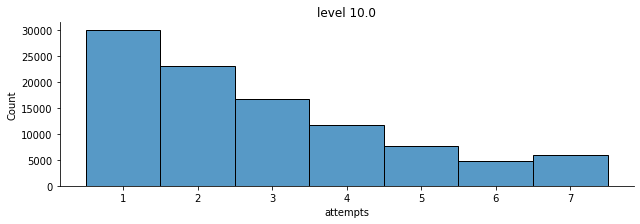

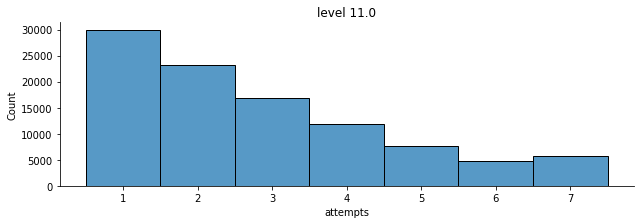

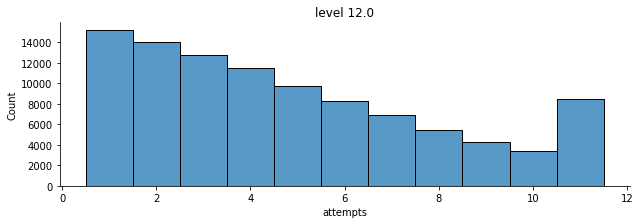

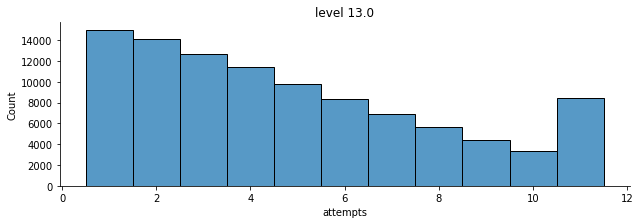

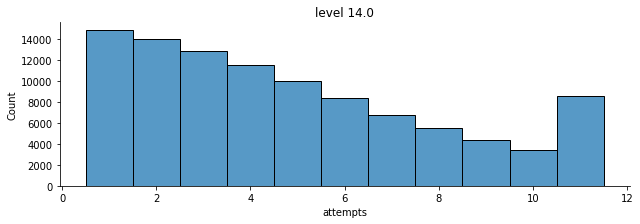

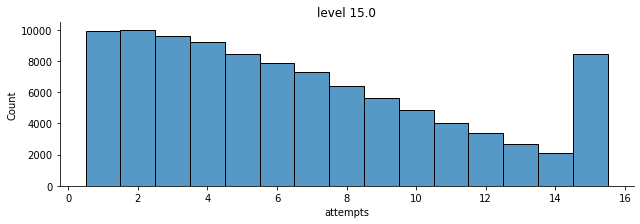

In [17]:
for level, gdf in df.query('level >= 7').groupby('level'):
    sb.displot(gdf, x='attempts', discrete=True, aspect=3, height=3)
    plt.title(f'level {level}')

## weapon honing

expected materials per level

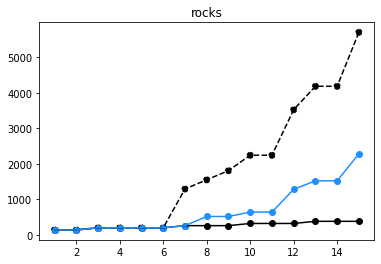

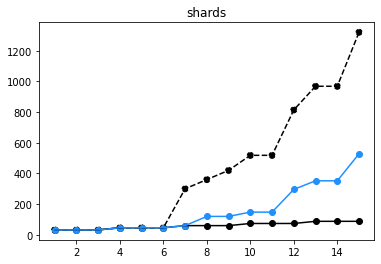

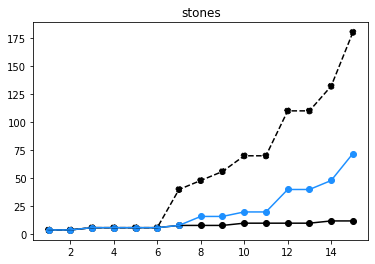

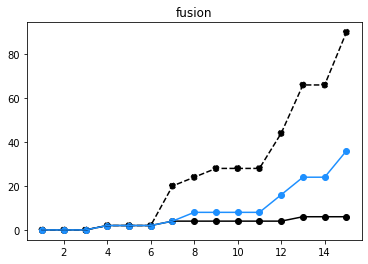

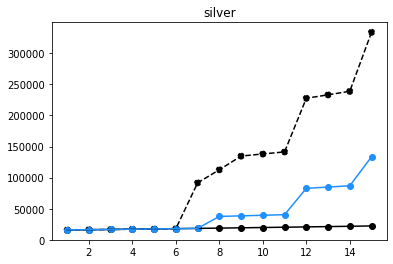

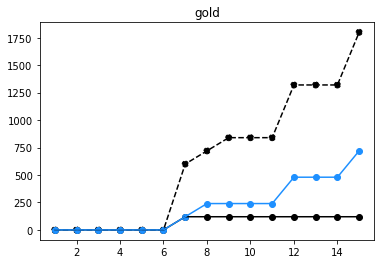

In [18]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '-'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * weapon_costs[resource]
        plt.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        plt.scatter(stats['level'], totals, ls=ls, color=color, label=stat)
        plt.title(resource)
    plt.show()

total expected materials

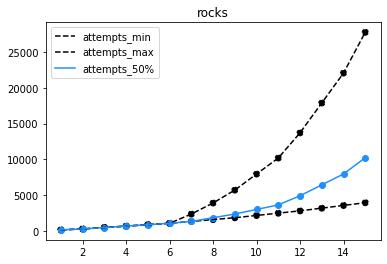

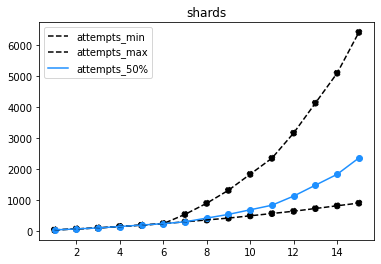

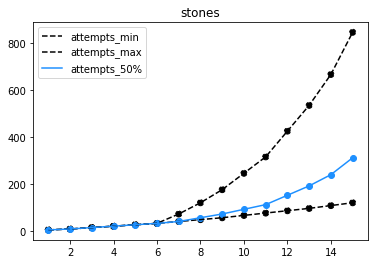

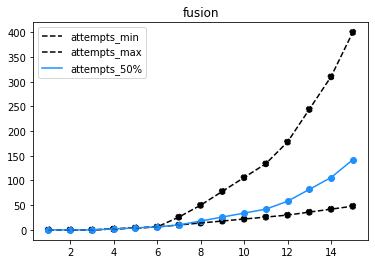

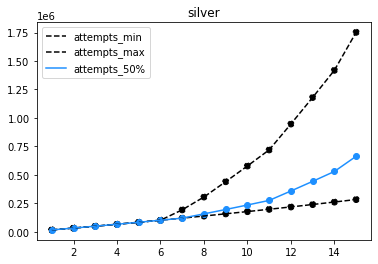

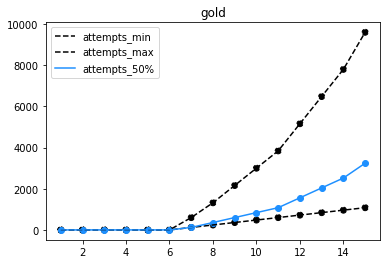

In [19]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '--'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        cumm_totals = (stats[stat] * weapon_costs[resource]).cumsum()
        plt.plot(stats['level'], cumm_totals, label=stat, color=color, ls=ls)
        plt.scatter(stats['level'], cumm_totals, label=None, color=color, ls=ls)
        plt.legend()
        plt.title(resource)
    plt.show()

In [20]:
for resource in resources:
    print(resource)
    print(
        stats[['attempts_min', 'attempts_50%', 'attempts_max']]
        .multiply(weapon_costs[resource], axis=0)
        .cumsum()
        .assign(level=stats.level)
    )
    print()

rocks
    attempts_min  attempts_50%  attempts_max  level
0            138           138           138      1
1            276           276           276      2
2            474           474           474      3
3            672           672           672      4
4            870           870           870      5
5           1068          1068          1068      6
6           1326          1326          2358      7
7           1584          1842          3906      8
8           1842          2358          5712      9
9           2162          2998          7952     10
10          2482          3638         10192     11
11          2802          4918         13712     12
12          3182          6438         17892     13
13          3562          7958         22072     14
14          3942         10238         27772     15

shards
    attempts_min  attempts_50%  attempts_max  level
0             32            32            32      1
1             64            64            64      

## gear honing

resources per level

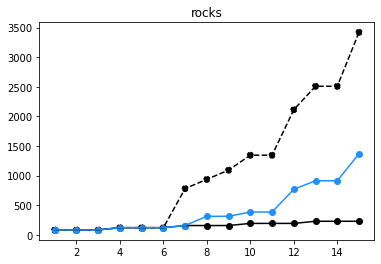

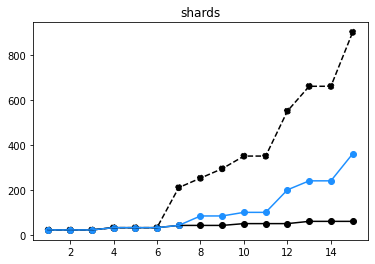

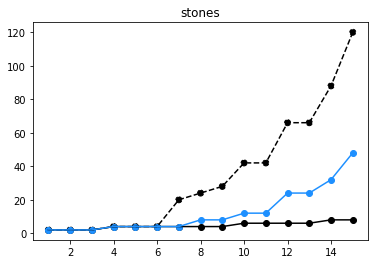

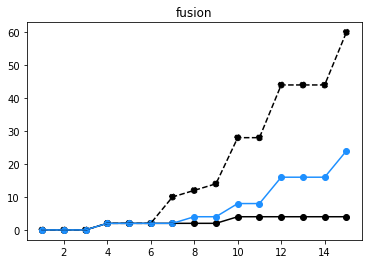

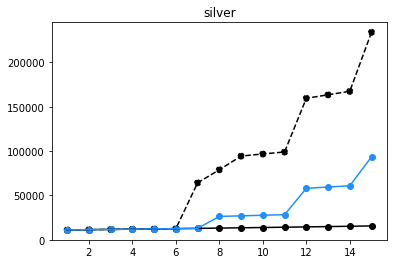

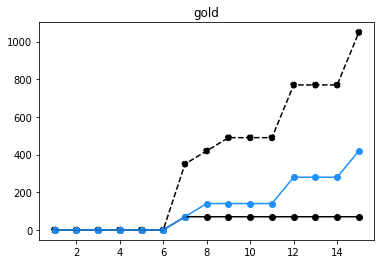

In [21]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '-'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * gear_costs[resource]
        plt.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        plt.scatter(gear_costs['level'], totals, ls=ls, color=color, label=stat)
        plt.title(resource)
    plt.show()

total resources

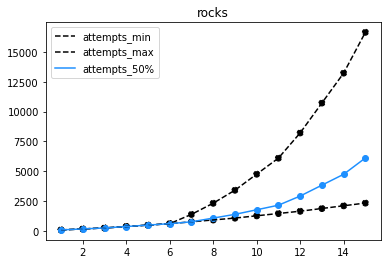

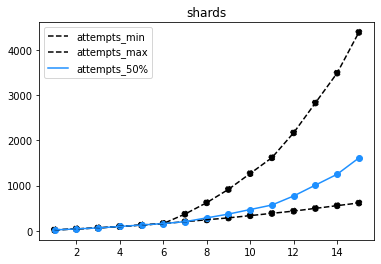

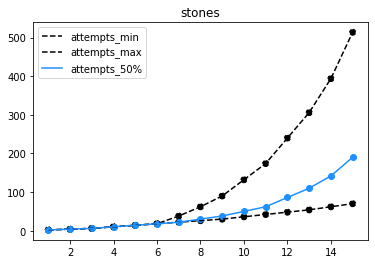

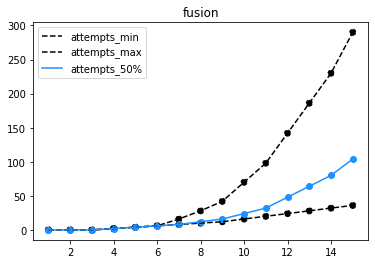

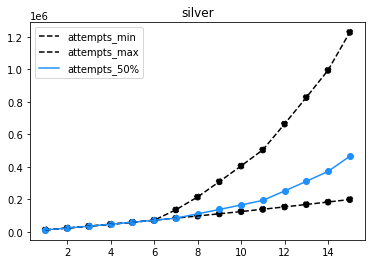

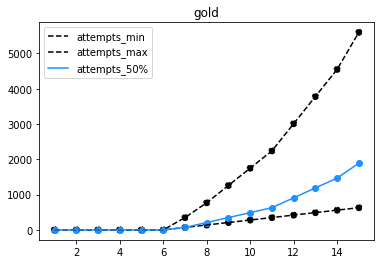

In [22]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '--'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        cumm_totals = (stats[stat] * gear_costs[resource]).cumsum()
        plt.plot(stats['level'], cumm_totals, label=stat, color=color, ls=ls)
        plt.scatter(stats['level'], cumm_totals, label=None, color=color, ls=ls)
        plt.legend()
        plt.title(resource)
    plt.show()

In [23]:
for resource in resources:
    print(resource)
    print(
        stats[['attempts_min', 'attempts_50%', 'attempts_max']]
        .multiply(gear_costs[resource], axis=0)
        .cumsum()
        .assign(level=stats.level)
        .astype(int)
    )
    print()

rocks
    attempts_min  attempts_50%  attempts_max  level
0             82            82            82      1
1            164           164           164      2
2            246           246           246      3
3            366           366           366      4
4            486           486           486      5
5            606           606           606      6
6            762           762          1386      7
7            918          1074          2322      8
8           1074          1386          3414      9
9           1266          1770          4758     10
10          1458          2154          6102     11
11          1650          2922          8214     12
12          1878          3834         10722     13
13          2106          4746         13230     14
14          2334          6114         16650     15

shards
    attempts_min  attempts_50%  attempts_max  level
0             22            22            22      1
1             44            44            44      

In [24]:
__df = df.merge(weapon_costs, on='level')

In [25]:
for resource in resources:
    __df[resource] *= __df['attempts']
__df

,trial,level,attempts,rocks,shards,stones,fusion,silver,gold
0,1,1.0,1,138,32,4,0,15860,0
1,2,1.0,1,138,32,4,0,15860,0
2,3,1.0,1,138,32,4,0,15860,0
3,4,1.0,1,138,32,4,0,15860,0
4,5,1.0,1,138,32,4,0,15860,0
...,...,...,...,...,...,...,...,...,...
1499995,99996,15.0,9,3420,792,108,54,200340,1080
1499996,99997,15.0,2,760,176,24,12,44520,240
1499997,99998,15.0,4,1520,352,48,24,89040,480
1499998,99999,15.0,12,4560,1056,144,72,267120,1440


In [26]:
__df = (
    __df
    .melt(
        id_vars=['level', 'trial'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
__df

,level,trial,resource,total
0,1.0,1,rocks,138
1,1.0,2,rocks,138
2,1.0,3,rocks,138
3,1.0,4,rocks,138
4,1.0,5,rocks,138
...,...,...,...,...
8999995,15.0,99996,gold,1080
8999996,15.0,99997,gold,240
8999997,15.0,99998,gold,480
8999998,15.0,99999,gold,1440


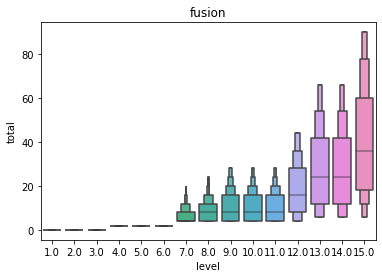

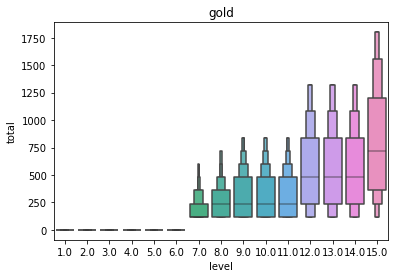

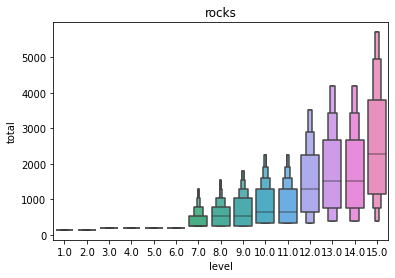

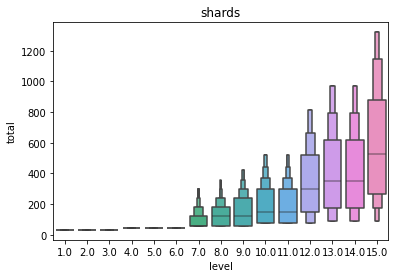

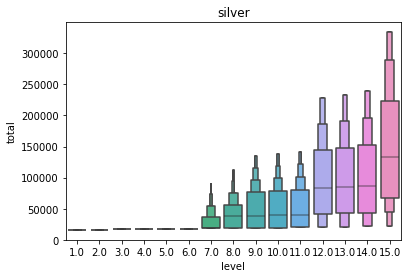

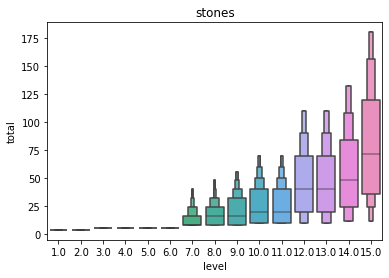

In [27]:
for res, gdf in __df.groupby('resource'):
    sb.boxenplot(data=gdf, x='level', y='total')
    plt.title(res)
    plt.show()

In [28]:
tdf = __df.groupby(['trial', 'resource'])['total'].sum().reset_index()
tdf

,trial,resource,total
0,1,fusion,202
1,1,gold,4440
2,1,rocks,14038
3,1,shards,3238
4,1,silver,881610
...,...,...,...
599995,100000,gold,3840
599996,100000,rocks,11650
599997,100000,shards,2686
599998,100000,silver,763290


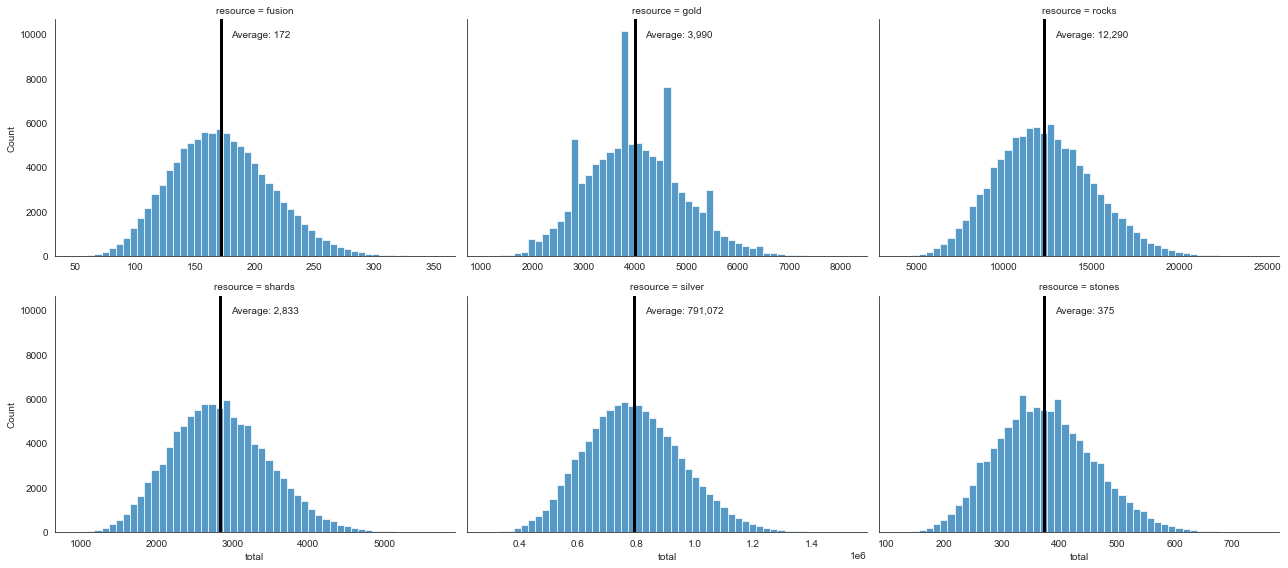

In [29]:
sb.set_style('white')
g = sb.FacetGrid(tdf, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .925),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')

In [30]:
__df = df.merge(gear_costs, on='level')

In [31]:
for resource in ('rocks', 'shards', 'stones', 'fusion', 'silver', 'gold'):
    __df[resource] *= __df['attempts']
__df

,trial,level,attempts,rocks,shards,stones,fusion,silver,gold
0,1,1.0,1,82,22,2,0,11100,0
1,2,1.0,1,82,22,2,0,11100,0
2,3,1.0,1,82,22,2,0,11100,0
3,4,1.0,1,82,22,2,0,11100,0
4,5,1.0,1,82,22,2,0,11100,0
...,...,...,...,...,...,...,...,...,...
1499995,99996,15.0,9,2052,540,72,36,140400,630
1499996,99997,15.0,2,456,120,16,8,31200,140
1499997,99998,15.0,4,912,240,32,16,62400,280
1499998,99999,15.0,12,2736,720,96,48,187200,840


In [32]:
__df = (
    __df
    .melt(
        id_vars=['level', 'trial'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
__df

,level,trial,resource,total
0,1.0,1,rocks,82
1,1.0,2,rocks,82
2,1.0,3,rocks,82
3,1.0,4,rocks,82
4,1.0,5,rocks,82
...,...,...,...,...
8999995,15.0,99996,gold,630
8999996,15.0,99997,gold,140
8999997,15.0,99998,gold,280
8999998,15.0,99999,gold,840


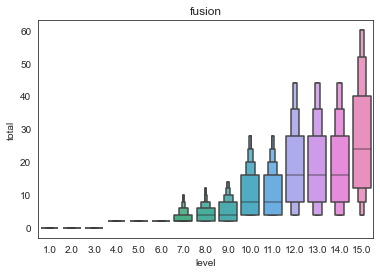

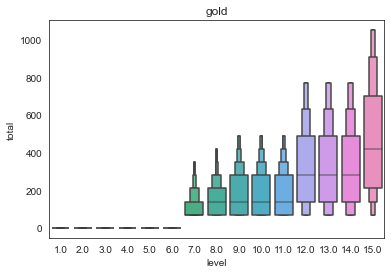

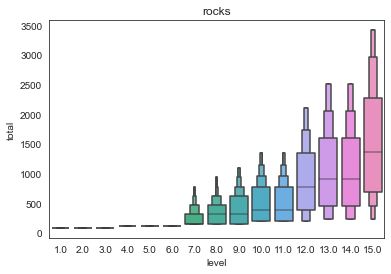

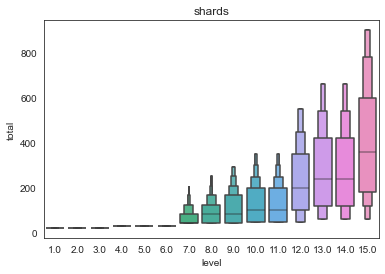

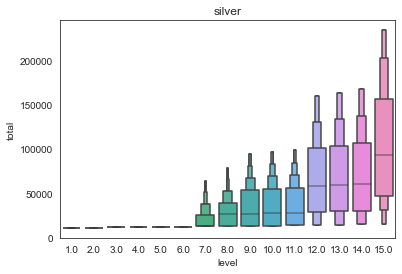

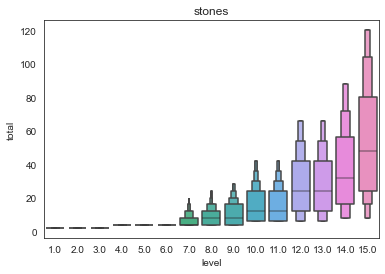

In [33]:
for res, gdf in __df.groupby('resource'):
    sb.boxenplot(data=gdf, x='level', y='total')
    plt.title(res)
    plt.show()

In [34]:
tdf = __df.groupby(['trial', 'resource'])['total'].sum().reset_index()
tdf

,trial,resource,total
0,1,fusion,144
1,1,gold,2590
2,1,rocks,8394
3,1,shards,2212
4,1,silver,617820
...,...,...,...
599995,100000,gold,2240
599996,100000,rocks,6966
599997,100000,shards,1840
599998,100000,silver,534920


Text(0.5, 1.02, 'Gear Honing Totals')

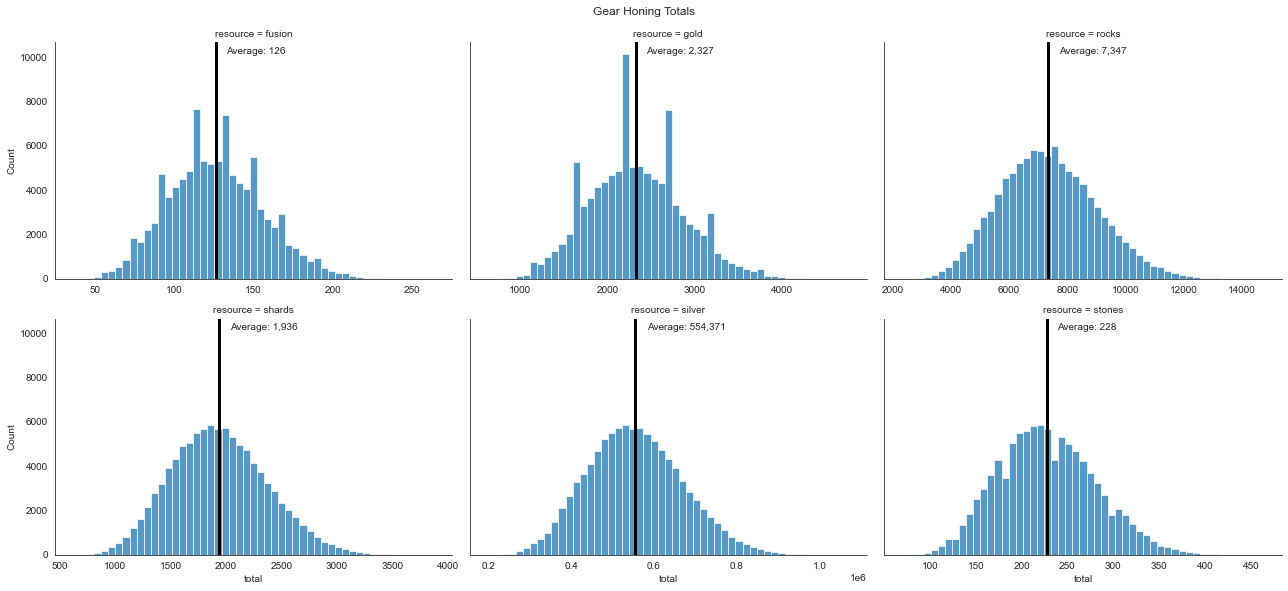

In [35]:
sb.set_style('white')
g = sb.FacetGrid(tdf, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .95),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')
plt.suptitle('Gear Honing Totals', y=1.02)

# ROAD TO 1490

In [36]:
probabilities = pd.DataFrame(
    columns=('level', 'ilvl', 'base_rate'),
    data=[
        ( 7, 1375, 0.60),
        ( 8, 1380, 0.45),
        ( 9, 1385, 0.30),
        (10, 1390, 0.30),
        (11, 1395, 0.30),
        (12, 1400, 0.15),
        (13, 1405, 0.15),
        (14, 1410, 0.15),
        (15, 1415, 0.10),
        (16, 1430, 0.10),
        (17, 1445, 0.10),
        (18, 1460, 0.05),
        (19, 1475, 0.05),
        (20, 1490, 0.03),
    ]
)
probabilities

,level,ilvl,base_rate
0,7,1375,0.60
1,8,1380,0.45
2,9,1385,0.30
3,10,1390,0.30
4,11,1395,0.30
5,12,1400,0.15
6,13,1405,0.15
7,14,1410,0.15
8,15,1415,0.10
9,16,1430,0.10


In [37]:
gear_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 7, 404, 108,  8,  6, 22380, 170),
        ( 8, 404, 108, 10,  6, 22920, 170),
        ( 9, 404, 108, 10,  6, 23480, 170),
        (10, 498, 132, 10,  8, 24040, 170),
        (11, 498, 132, 10,  8, 24640, 170),
        (12, 498, 132, 12,  8, 25240, 170),
        (13, 592, 158, 12,  8, 25860, 170),
        (14, 592, 158, 12,  8, 26500, 170),
        (15, 592, 158, 12,  8, 27160, 180),
        (16, 686, 216, 14, 10, 27820, 210),
        (17, 686, 292, 16, 10, 28420, 250),
        (18, 686, 396, 16, 12, 29040, 280),
        (19, 780, 536, 18, 14, 29660, 320),
        (20, 780, 728, 20, 14, 30320, 350),
    ]
)
gear_costs

,level,rocks,shards,stones,fusion,silver,gold
0,7,404,108,8,6,22380,170
1,8,404,108,10,6,22920,170
2,9,404,108,10,6,23480,170
3,10,498,132,10,8,24040,170
4,11,498,132,10,8,24640,170
5,12,498,132,12,8,25240,170
6,13,592,158,12,8,25860,170
7,14,592,158,12,8,26500,170
8,15,592,158,12,8,27160,180
9,16,686,216,14,10,27820,210


In [38]:
weapon_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 7,  672,  156, 12,  6, 31920, 320),
        ( 8,  672,  156, 14,  6, 32700, 320),
        ( 9,  672,  156, 14,  8, 33520, 320),
        (10,  830,  192, 16,  8, 34340, 320),
        (11,  830,  192, 16,  8, 35180, 330),
        (12,  830,  192, 18,  8, 36040, 330),
        (13,  968,  228, 18, 10, 36940, 330),
        (14,  968,  228, 20, 10, 37840, 330),
        (15,  968,  228, 20, 10, 38760, 330),
        (16, 1144,  310, 22, 12, 39720, 410),
        (17, 1144,  422, 24, 14, 40580, 480),
        (18, 1144,  572, 28, 16, 41460, 540),
        (19, 1300,  776, 30, 18, 42360, 640),
        (20, 1300, 1054, 32, 20, 43260, 730),
    ]
)
weapon_costs

,level,rocks,shards,stones,fusion,silver,gold
0,7,672,156,12,6,31920,320
1,8,672,156,14,6,32700,320
2,9,672,156,14,8,33520,320
3,10,830,192,16,8,34340,320
4,11,830,192,16,8,35180,330
5,12,830,192,18,8,36040,330
6,13,968,228,18,10,36940,330
7,14,968,228,20,10,37840,330
8,15,968,228,20,10,38760,330
9,16,1144,310,22,12,39720,410


According to [earymari](https://www.easymari.com/en/t3_gear_honing_statistics) the success rate for an item increases by 0.1 * base_rate and artisan rate increases by 0.456 * current_rate. Upgrade chance becomes 100% once artisan rate reaches 100%. Success rate caps at 2 * base_rate.

In [39]:
rates = []
for _, row in probabilities.iterrows():
    attempt = 0
    artisan_rate = 0.00
    success_rate = row.base_rate
    increase_rate = row.base_rate * 0.1
    while True:
        attempt += 1
        if artisan_rate >= 1 or success_rate >= 1:
            break
        rates.append((row.level, attempt, success_rate))
        artisan_rate = np.round(artisan_rate + 0.465 * success_rate, 4)
        success_rate = np.round(np.min([success_rate + increase_rate, 2 * row.base_rate]), 4)
    rates.append((row.level, attempt, 1.0))

rates = pd.DataFrame(rates, columns=('level', 'attempts', 'success_rate'))
# rates.to_csv('rates.csv', index=False)
rates

,level,attempts,success_rate
0,7.0,1,0.60
1,7.0,2,0.66
2,7.0,3,0.72
3,7.0,4,0.78
4,7.0,5,1.00
...,...,...,...
197,20.0,36,0.06
198,20.0,37,0.06
199,20.0,38,0.06
200,20.0,39,0.06


In [40]:
df = (
    pd.concat([
        rates.assign(trial=i+1)
        for i in range(num_simulations)
    ])
    .assign(roll=np.random.uniform(size=rates.shape[0]*num_simulations))
    .query('roll < success_rate')
    .drop(['roll', 'success_rate'], axis=1)
    .groupby(['trial', 'level'], as_index=False)
    .first()
)

df

,trial,level,attempts
0,1,7.0,2
1,1,8.0,3
2,1,9.0,4
3,1,10.0,3
4,1,11.0,6
...,...,...,...
1399995,100000,16.0,5
1399996,100000,17.0,1
1399997,100000,18.0,7
1399998,100000,19.0,5


In [41]:
df.pivot(index='trial', columns='level')

attempts                                                              \
level      7.0  8.0  9.0  10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0   
trial                                                                         
1             2    3    4    3    6    7    2    2    6    4   11   26    6   
2             3    3    3    3    2    8    4   11    1    3    9   10    3   
3             2    1    4    1    1   11    8    9    6   11   15   10   24   
4             2    1    7    4    3    3    4    5    2    8    7   26   14   
5             1    4    7    3    1    9    6    1    4    3    1    2   13   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99996         3    5    5    1    3    3    1   11    1   13    2   16   26   
99997         1    2    2    2    2    3    3    9    6    3    9    7    3   
99998         3    1    1    1    1    4    3    3   15    4    8   13   15   
99999         2    1    7    1    3    1    2    2    6   14    5   16   11   
100000        1    1    1    2    2    1    4    3    8    5    1    7    5   

             
level  20.0  
trial        
1        13  
2        12  
3        31  
4        11  
5        12  
...     ...  
99996    40  
99997    15  
99998    39  
99999    25  
100000   23  

[100000 rows x 14 columns]

<AxesSubplot:xlabel='level', ylabel='attempts'>

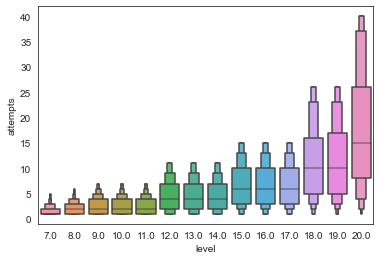

In [42]:
sb.boxenplot(data=df, x='level', y='attempts')

cummulative success probabilities

In [43]:
(
    (
        df
        .drop('trial', axis=1)
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempts')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .fillna('--')
)

p                                                        ...  \
attempts    1     2     3     4     5     6     7     8     9     10  ...   
level                                                                 ...   
7.0       0.60  0.86  0.96  0.99  1.00    --    --    --    --    --  ...   
8.0       0.45  0.72  0.87  0.95  0.98   1.0    --    --    --    --  ...   
9.0       0.30  0.53  0.70  0.82  0.89  0.94   1.0    --    --    --  ...   
10.0      0.30  0.53  0.70  0.82  0.89  0.94   1.0    --    --    --  ...   
11.0      0.30  0.53  0.70  0.82  0.89  0.94   1.0    --    --    --  ...   
12.0      0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.92  ...   
13.0      0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.91  ...   
14.0      0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.91  ...   
15.0      0.10  0.20  0.29  0.39  0.47  0.55  0.62  0.69  0.74  0.79  ...   
16.0      0.10  0.20  0.29  0.39  0.47  0.55  0.63  0.69  0.75  0.79  ...   
17.0      0.10  0.20  0.30  0.39  0.47  0.55  0.62  0.69  0.74  0.79  ...   
18.0      0.05  0.10  0.16  0.21  0.27  0.32  0.37  0.43  0.48  0.53  ...   
19.0      0.05  0.10  0.16  0.21  0.27  0.32  0.38  0.43  0.48  0.53  ...   
20.0      0.03  0.06  0.10  0.13  0.17   0.2  0.24  0.28  0.32  0.36  ...   

                                                                     
attempts    31    32    33    34    35    36    37    38    39   40  
level                                                                
7.0         --    --    --    --    --    --    --    --    --   --  
8.0         --    --    --    --    --    --    --    --    --   --  
9.0         --    --    --    --    --    --    --    --    --   --  
10.0        --    --    --    --    --    --    --    --    --   --  
11.0        --    --    --    --    --    --    --    --    --   --  
12.0        --    --    --    --    --    --    --    --    --   --  
13.0        --    --    --    --    --    --    --    --    --   --  
14.0        --    --    --    --    --    --    --    --    --   --  
15.0        --    --    --    --    --    --    --    --    --   --  
16.0        --    --    --    --    --    --    --    --    --   --  
17.0        --    --    --    --    --    --    --    --    --   --  
18.0        --    --    --    --    --    --    --    --    --   --  
19.0        --    --    --    --    --    --    --    --    --   --  
20.0      0.83  0.84  0.85  0.86  0.86  0.87  0.88  0.89  0.89  1.0  

[14 rows x 40 columns]

failure rates by level

In [44]:
(
    (
        df
        .drop('trial', axis=1)
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempts')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .applymap(lambda p: 1-p)
    .fillna('--')
)

p                                                        ...  \
attempts    1     2     3     4     5     6     7     8     9     10  ...   
level                                                                 ...   
7.0       0.40  0.14  0.04  0.01  0.00    --    --    --    --    --  ...   
8.0       0.55  0.28  0.13  0.05  0.02   0.0    --    --    --    --  ...   
9.0       0.70  0.47  0.30  0.18  0.11  0.06   0.0    --    --    --  ...   
10.0      0.70  0.47  0.30  0.18  0.11  0.06   0.0    --    --    --  ...   
11.0      0.70  0.47  0.30  0.18  0.11  0.06   0.0    --    --    --  ...   
12.0      0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.08  ...   
13.0      0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.09  ...   
14.0      0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.09  ...   
15.0      0.90  0.80  0.71  0.61  0.53  0.45  0.38  0.31  0.26  0.21  ...   
16.0      0.90  0.80  0.71  0.61  0.53  0.45  0.37  0.31  0.25  0.21  ...   
17.0      0.90  0.80  0.70  0.61  0.53  0.45  0.38  0.31  0.26  0.21  ...   
18.0      0.95  0.90  0.84  0.79  0.73  0.68  0.63  0.57  0.52  0.47  ...   
19.0      0.95  0.90  0.84  0.79  0.73  0.68  0.62  0.57  0.52  0.47  ...   
20.0      0.97  0.94  0.90  0.87  0.83   0.8  0.76  0.72  0.68  0.64  ...   

                                                                     
attempts    31    32    33    34    35    36    37    38    39   40  
level                                                                
7.0         --    --    --    --    --    --    --    --    --   --  
8.0         --    --    --    --    --    --    --    --    --   --  
9.0         --    --    --    --    --    --    --    --    --   --  
10.0        --    --    --    --    --    --    --    --    --   --  
11.0        --    --    --    --    --    --    --    --    --   --  
12.0        --    --    --    --    --    --    --    --    --   --  
13.0        --    --    --    --    --    --    --    --    --   --  
14.0        --    --    --    --    --    --    --    --    --   --  
15.0        --    --    --    --    --    --    --    --    --   --  
16.0        --    --    --    --    --    --    --    --    --   --  
17.0        --    --    --    --    --    --    --    --    --   --  
18.0        --    --    --    --    --    --    --    --    --   --  
19.0        --    --    --    --    --    --    --    --    --   --  
20.0      0.17  0.16  0.15  0.14  0.14  0.13  0.12  0.11  0.11  0.0  

[14 rows x 40 columns]

expected attempts per level

In [45]:
stats = df.drop('trial', axis=1).groupby('level').describe(percentiles=[0.5])
stats.columns = ['_'.join(col) for col in stats.columns.to_flat_index()]
stats = (
    stats
    .reset_index()
    .drop(['attempts_count', 'attempts_mean', 'attempts_std'] , axis=1)
    .astype(int)
)
stats

,level,attempts_min,attempts_50%,attempts_max
0,7,1,1,5
1,8,1,2,6
2,9,1,2,7
3,10,1,2,7
4,11,1,2,7
5,12,1,4,11
6,13,1,4,11
7,14,1,4,11
8,15,1,6,15
9,16,1,6,15


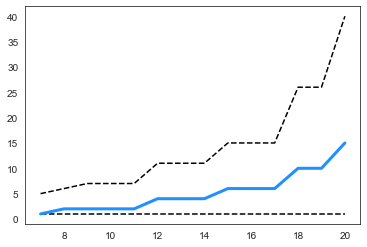

In [46]:
plt.plot(stats['level'], stats['attempts_min'], color='black', ls='--')
plt.plot(stats['level'], stats['attempts_max'], color='black', ls='--')
plt.plot(stats['level'], stats['attempts_50%'], color='dodgerblue', lw=3)

cummulative total attempts to +15

In [47]:
(
    stats
    .drop('level', axis=1)
    .apply(np.cumsum)
    .assign(level=stats['level'])
)

,attempts_min,attempts_50%,attempts_max,level
0,1,1,5,7
1,2,3,11,8
2,3,5,18,9
3,4,7,25,10
4,5,9,32,11
5,6,13,43,12
6,7,17,54,13
7,8,21,65,14
8,9,27,80,15
9,10,33,95,16


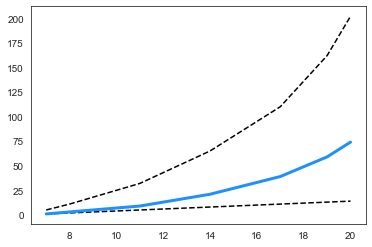

In [48]:
plt.plot(stats['level'], stats['attempts_min'].cumsum(), color='black', ls='--')
plt.plot(stats['level'], stats['attempts_max'].cumsum(), color='black', ls='--')
plt.plot(stats['level'], stats['attempts_50%'].cumsum(), color='dodgerblue', lw=3)

In [49]:
%pip install celluloid ffmpeg-python

     -------------------------------------- 829.2/829.2 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for future, since package 'wheel' is not installed.
  Running setup.py install for future: started
  Running setup.py install for future: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


RuntimeError: Requested MovieWriter (ffmpeg) not available

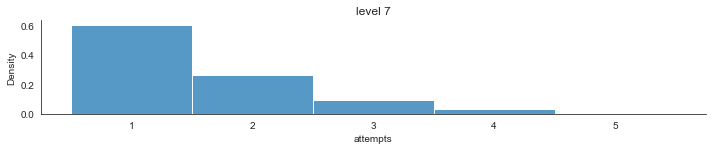

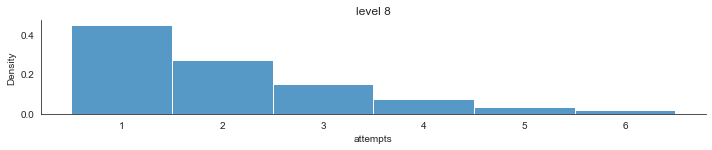

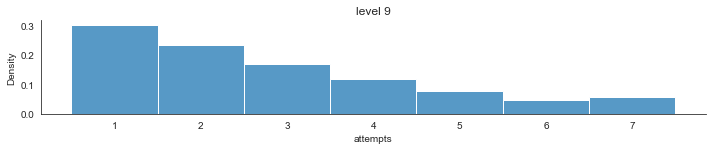

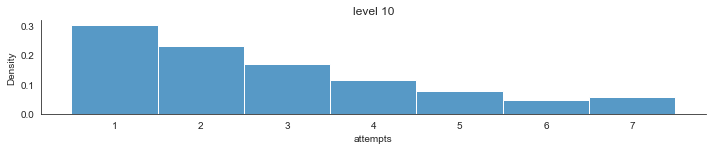

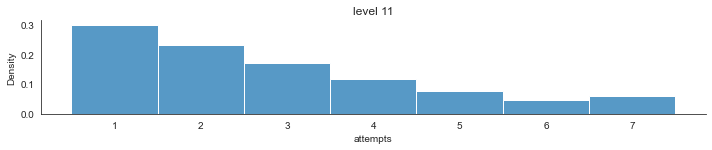

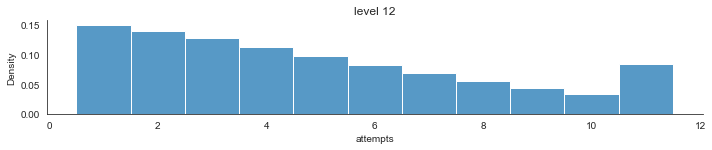

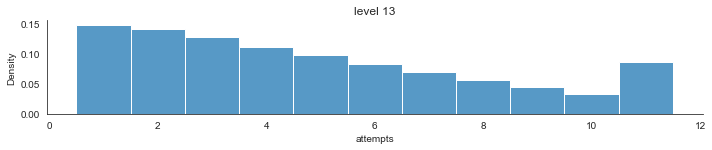

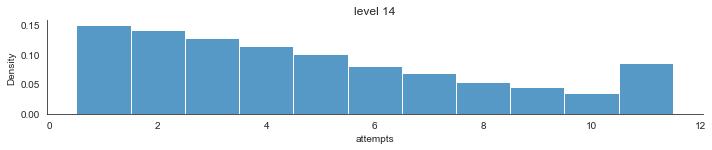

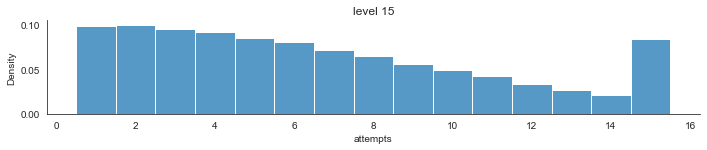

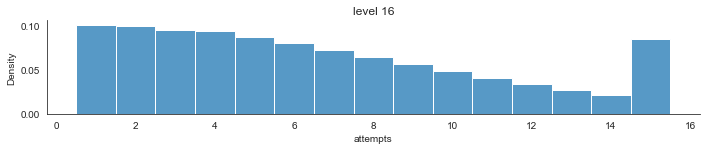

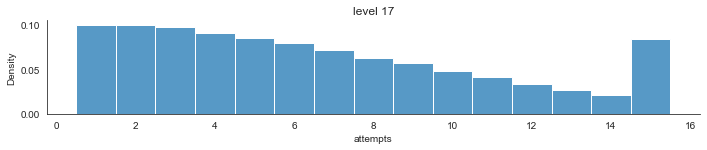

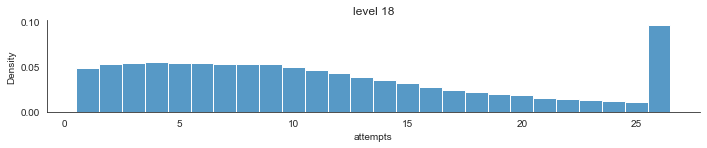

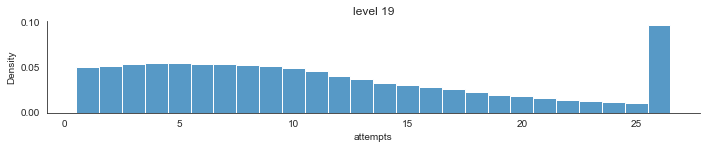

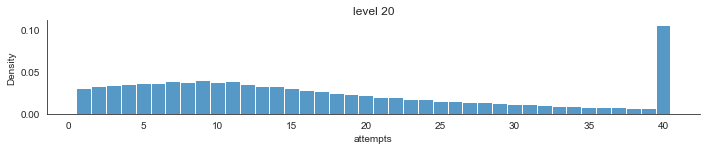

In [50]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.Figure()
cam = Camera(fig)

for level, gdf in df.query('level >= 7').groupby('level'):
    fig = sb.displot(gdf, x='attempts', discrete=True, stat='density', aspect=5, height=2)
    fig.ax.set_title(f'level {level:.0f}')
    cam.snap()

anim = cam.animate(blit=False)
HTML(anim.to_html5_video())

## weapon honing

expected materials per level

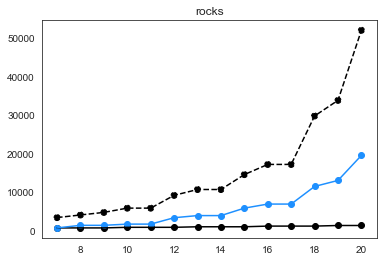

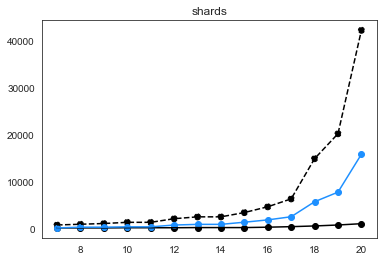

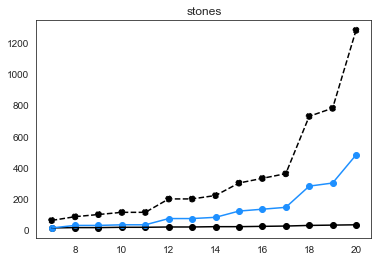

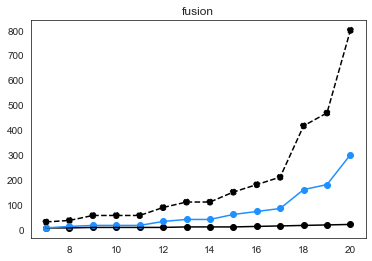

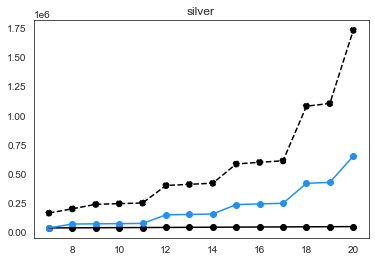

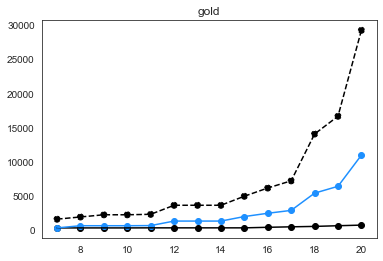

In [52]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '-'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * weapon_costs[resource]
        plt.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        plt.scatter(stats['level'], totals, ls=ls, color=color, label=stat)
        plt.title(resource)
    plt.show()

total expected materials

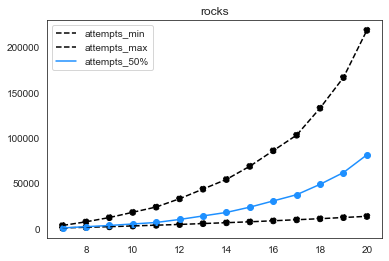

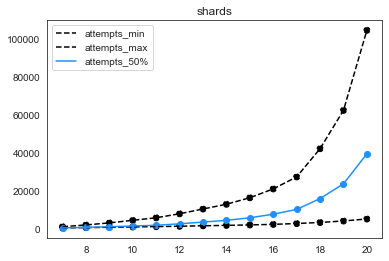

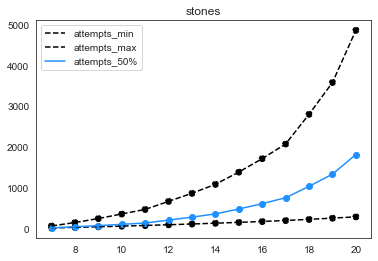

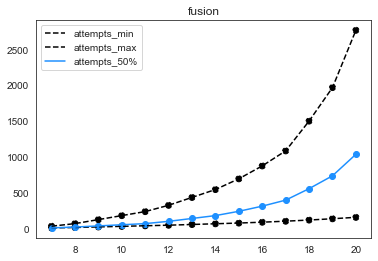

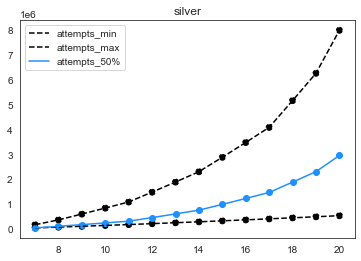

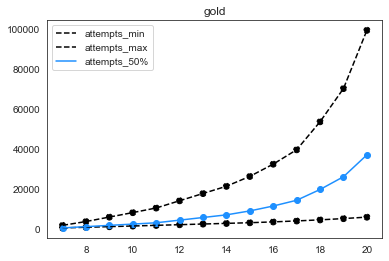

In [53]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '--'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        cumm_totals = (stats[stat] * weapon_costs[resource]).cumsum()
        plt.plot(stats['level'], cumm_totals, label=stat, color=color, ls=ls)
        plt.scatter(stats['level'], cumm_totals, label=None, color=color, ls=ls)
        plt.legend()
        plt.title(resource)
    plt.show()

In [54]:
for resource in resources:
    print(resource)
    print(
        stats[['attempts_min', 'attempts_50%', 'attempts_max']]
        .multiply(weapon_costs[resource], axis=0)
        .cumsum()
        .assign(level=stats.level)
    )
    print()

rocks
    attempts_min  attempts_50%  attempts_max  level
0            672           672          3360      7
1           1344          2016          7392      8
2           2016          3360         12096      9
3           2846          5020         17906     10
4           3676          6680         23716     11
5           4506         10000         32846     12
6           5474         13872         43494     13
7           6442         17744         54142     14
8           7410         23552         68662     15
9           8554         30416         85822     16
10          9698         37280        102982     17
11         10842         48720        132726     18
12         12142         61720        166526     19
13         13442         81220        218526     20

shards
    attempts_min  attempts_50%  attempts_max  level
0            156           156           780      7
1            312           468          1716      8
2            468           780          2808      

## gear honing

resources per level

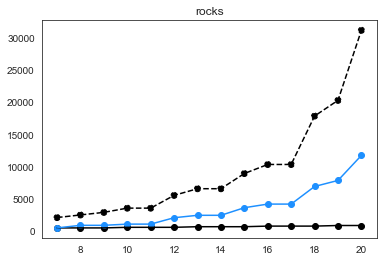

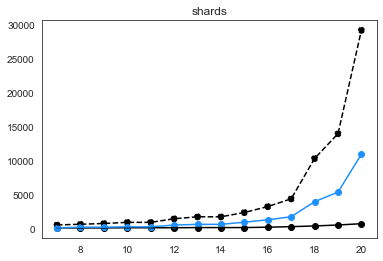

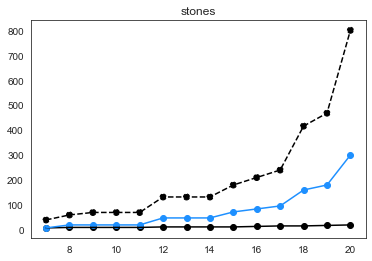

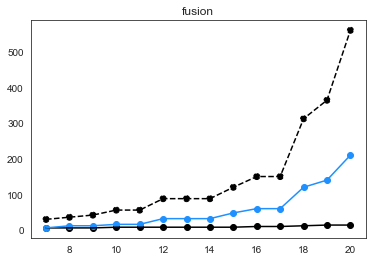

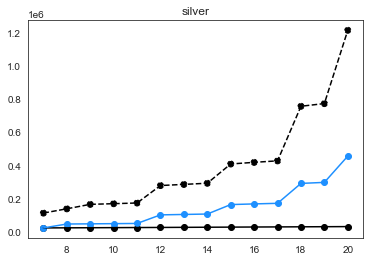

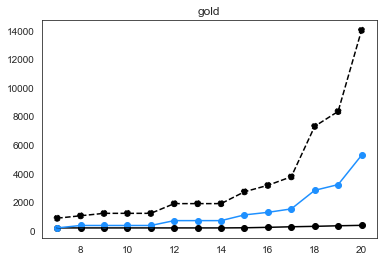

In [55]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '-'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * gear_costs[resource]
        plt.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        plt.scatter(gear_costs['level'], totals, ls=ls, color=color, label=stat)
        plt.title(resource)
    plt.show()

total resources

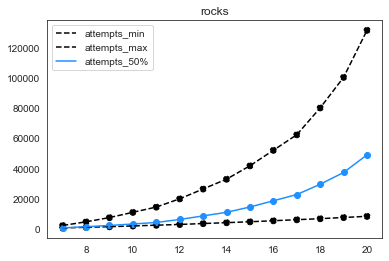

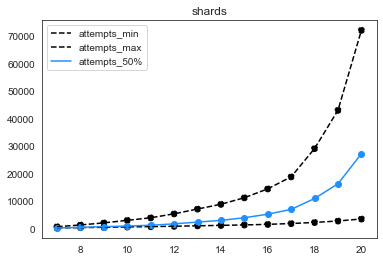

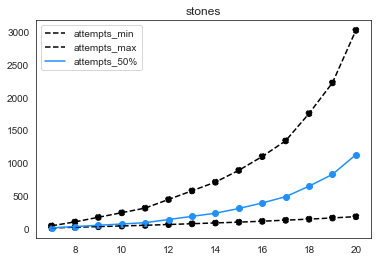

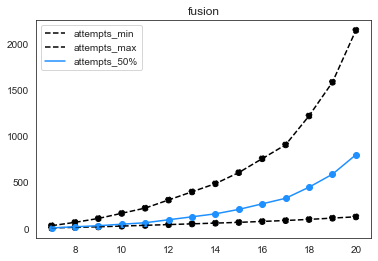

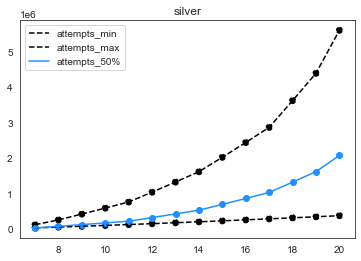

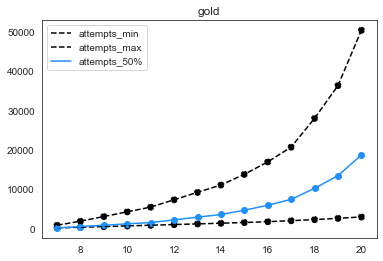

In [56]:
for resource in resources:
    for stat, color, ls in [
        ('attempts_min', 'black', '--'),
        ('attempts_max', 'black', '--'),
        ('attempts_50%', 'dodgerblue', '-'),
    ]:
        cumm_totals = (stats[stat] * gear_costs[resource]).cumsum()
        plt.plot(stats['level'], cumm_totals, label=stat, color=color, ls=ls)
        plt.scatter(stats['level'], cumm_totals, label=None, color=color, ls=ls)
        plt.legend()
        plt.title(resource)
    plt.show()

In [57]:
for resource in resources:
    print(resource)
    print(
        stats[['attempts_min', 'attempts_50%', 'attempts_max']]
        .multiply(gear_costs[resource], axis=0)
        .cumsum()
        .assign(level=stats.level)
        .astype(int)
    )
    print()

rocks
    attempts_min  attempts_50%  attempts_max  level
0            404           404          2020      7
1            808          1212          4444      8
2           1212          2020          7272      9
3           1710          3016         10758     10
4           2208          4012         14244     11
5           2706          6004         19722     12
6           3298          8372         26234     13
7           3890         10740         32746     14
8           4482         14292         41626     15
9           5168         18408         51916     16
10          5854         22524         62206     17
11          6540         29384         80042     18
12          7320         37184        100322     19
13          8100         48884        131522     20

shards
    attempts_min  attempts_50%  attempts_max  level
0            108           108           540      7
1            216           324          1188      8
2            324           540          1944      

In [58]:
__df = df.merge(weapon_costs, on='level')

In [59]:
for resource in resources:
    __df[resource] *= __df['attempts']
__df

,trial,level,attempts,rocks,shards,stones,fusion,silver,gold
0,1,7.0,1,672,156,12,6,31920,320
1,2,7.0,1,672,156,12,6,31920,320
2,3,7.0,2,1344,312,24,12,63840,640
3,4,7.0,1,672,156,12,6,31920,320
4,5,7.0,1,672,156,12,6,31920,320
...,...,...,...,...,...,...,...,...,...
1399995,99996,20.0,22,28600,23188,704,440,951720,16060
1399996,99997,20.0,10,13000,10540,320,200,432600,7300
1399997,99998,20.0,40,52000,42160,1280,800,1730400,29200
1399998,99999,20.0,12,15600,12648,384,240,519120,8760


In [60]:
__df = (
    __df
    .melt(
        id_vars=['level', 'trial'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
__df

,level,trial,resource,total
0,7.0,1,rocks,672
1,7.0,2,rocks,672
2,7.0,3,rocks,1344
3,7.0,4,rocks,672
4,7.0,5,rocks,672
...,...,...,...,...
8399995,20.0,99996,gold,16060
8399996,20.0,99997,gold,7300
8399997,20.0,99998,gold,29200
8399998,20.0,99999,gold,8760


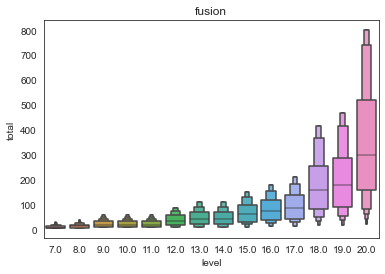

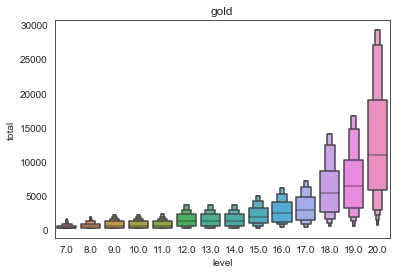

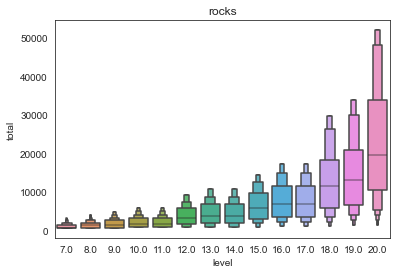

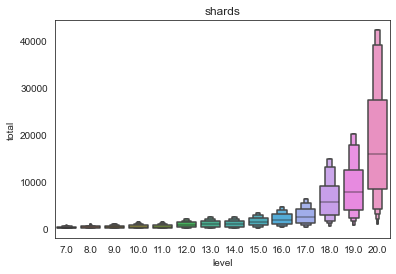

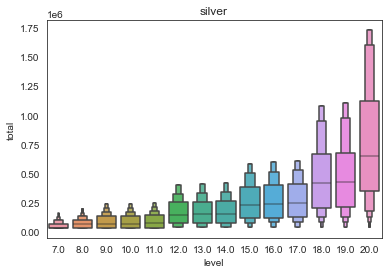

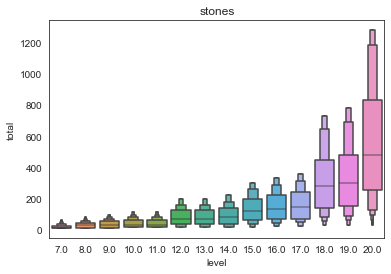

In [61]:
for res, gdf in __df.groupby('resource'):
    sb.boxenplot(data=gdf, x='level', y='total')
    plt.title(res)
    plt.show()

In [62]:
tdf = __df.groupby(['trial', 'resource'])['total'].sum().reset_index()
tdf

,trial,resource,total
0,1,fusion,1116
1,1,gold,38990
2,1,rocks,91222
3,1,shards,36868
4,1,silver,3335840
...,...,...,...
599995,100000,gold,22370
599996,100000,rocks,55820
599997,100000,shards,17684
599998,100000,silver,2133320


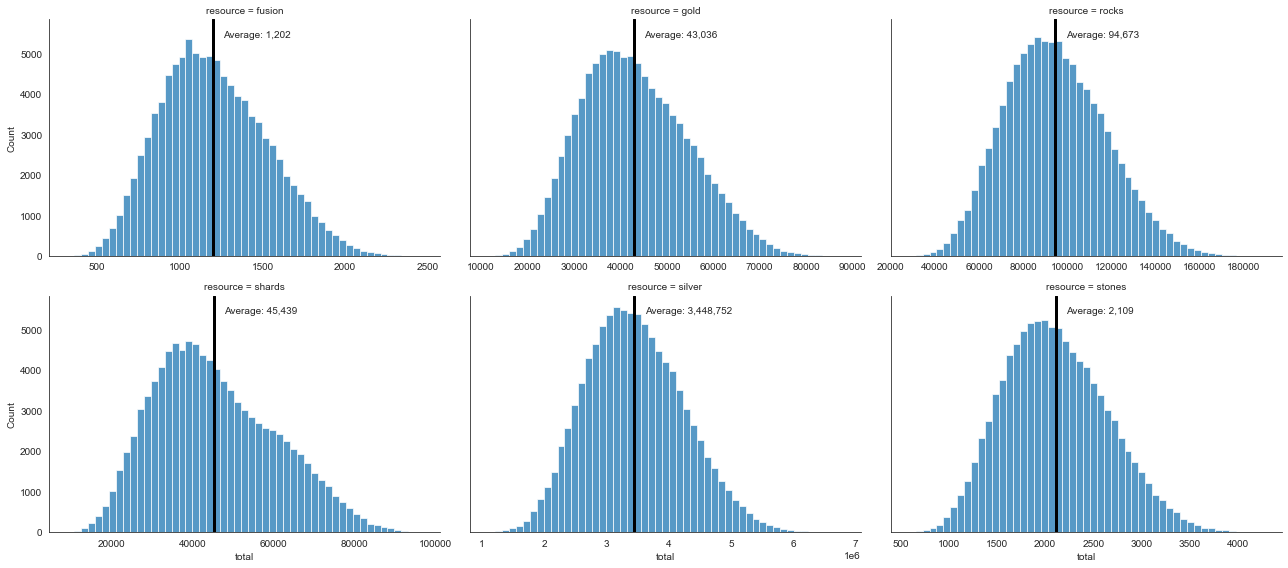

In [63]:
sb.set_style('white')
g = sb.FacetGrid(tdf, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .925),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')

In [64]:
__df = df.merge(gear_costs, on='level')

In [65]:
for resource in ('rocks', 'shards', 'stones', 'fusion', 'silver', 'gold'):
    __df[resource] *= __df['attempts']
__df

,trial,level,attempts,rocks,shards,stones,fusion,silver,gold
0,1,7.0,1,404,108,8,6,22380,170
1,2,7.0,1,404,108,8,6,22380,170
2,3,7.0,2,808,216,16,12,44760,340
3,4,7.0,1,404,108,8,6,22380,170
4,5,7.0,1,404,108,8,6,22380,170
...,...,...,...,...,...,...,...,...,...
1399995,99996,20.0,22,17160,16016,440,308,667040,7700
1399996,99997,20.0,10,7800,7280,200,140,303200,3500
1399997,99998,20.0,40,31200,29120,800,560,1212800,14000
1399998,99999,20.0,12,9360,8736,240,168,363840,4200


In [66]:
__df = (
    __df
    .melt(
        id_vars=['level', 'trial'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
__df

,level,trial,resource,total
0,7.0,1,rocks,404
1,7.0,2,rocks,404
2,7.0,3,rocks,808
3,7.0,4,rocks,404
4,7.0,5,rocks,404
...,...,...,...,...
8399995,20.0,99996,gold,7700
8399996,20.0,99997,gold,3500
8399997,20.0,99998,gold,14000
8399998,20.0,99999,gold,4200


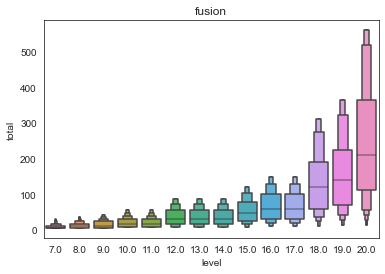

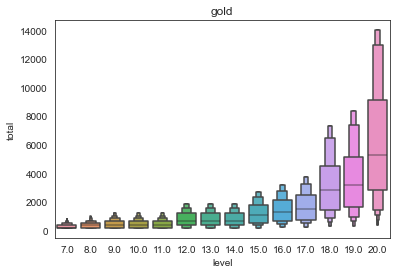

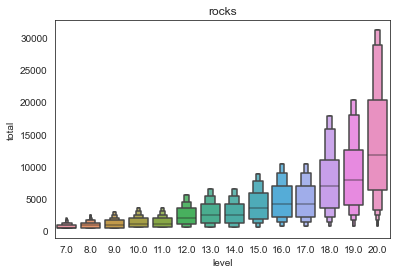

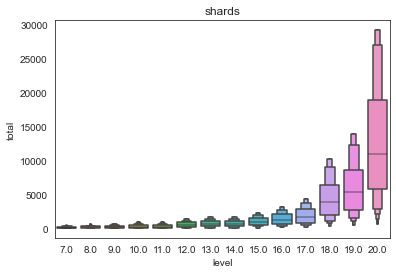

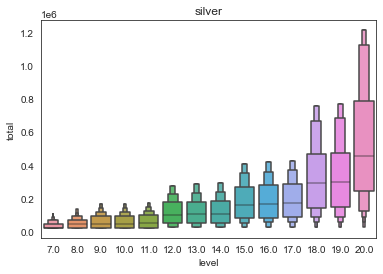

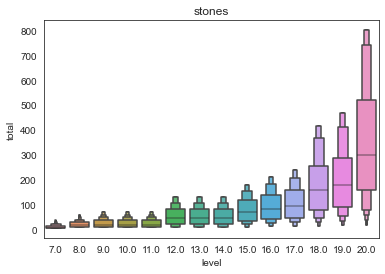

In [67]:
for res, gdf in __df.groupby('resource'):
    sb.boxenplot(data=gdf, x='level', y='total')
    plt.title(res)
    plt.show()

In [68]:
tdf = __df.groupby(['trial', 'resource'])['total'].sum().reset_index()
tdf

,trial,resource,total
0,1,fusion,874
1,1,gold,20100
2,1,rocks,54898
3,1,shards,25512
4,1,silver,2336460
...,...,...,...
599995,100000,gold,11560
599996,100000,rocks,33622
599997,100000,shards,12248
599998,100000,silver,1494200


Text(0.5, 1.02, 'Gear Honing Totals')

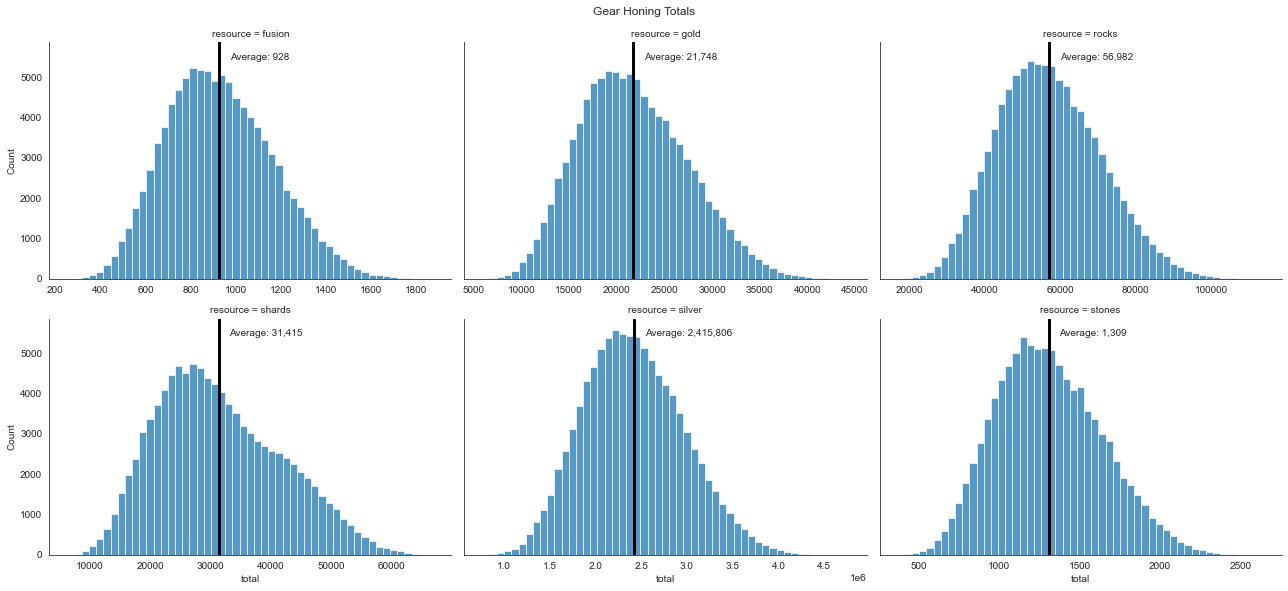

In [69]:
sb.set_style('white')
g = sb.FacetGrid(tdf, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .925),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')
plt.suptitle('Gear Honing Totals', y=1.02)